In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import psycopg2

Define EM Algorithm

In [28]:
def GMM(dat, k):
    p_class=np.zeros(k)
    
    #This represents μ_m (mean values of each component) (slide 26)
    means=np.zeros((k,2))
    
    #This represents Σ_m (covariance matrix) (slide 26)
    covars=np.zeros((k,2,2))
    
    #This represets p̃_mi (slide 27)
    p_data_given_class=np.zeros((len(dat),k))

    #This is just used at the end to compute mean dist
    mean_dist=np.array(0)
    
    #initializations of initial points (used to set the initial menas lower down)
    init_idx=np.random.choice(range(len(dat)), size=k, replace=False)
    
    """Initialize means, covs, p_classes"""
    #Initialize the covariance matrix, the means, and the p_class for each of k components (dims)
    for dim in range(k):
        #Set the cov matrix of each component to the cov of the entire dataset (slide 26)
        covars[dim,:,:]=np.cov(np.transpose(dat))

        #Set initial means to initial chosen data points (slide 26)
        means[dim,:]=dat.iloc[init_idx[dim]]
        
        #Give each component equal weighting / likelihood to start (slide 26)
        p_class[dim]=1/k
        
    
    #Now we start our for loop, where-in we'll alernate between: (1) Expecation Step and (2) Maximization Step
    for step in range(50):  
        for dim in range(k):
            #Use pdf to get prob of each data point given component (dim) (slide 27)
            p_data_given_class[:,dim]=  np.array([stats.multivariate_normal.pdf(x=dat, mean=means[dim,:], cov=covars[dim,:,:], allow_singular = True)])
            #What we have now is P(x_i | cluster = m). We still need to multiply by P(cluster = m)
            
        #Multiply by p_class (slide 27)
        p_class_given_data=p_data_given_class*p_class

        #Now consolidate into probabilities using 1/α_i (slide 27)
        sums=np.sum(p_class_given_data, axis=1)

        for dim in range(k):
            #For each class, divide by the sum to convert to probabilities (slide 27)
            #p_class_given_data now represents p̂_mi
            p_class_given_data[:,dim]=p_class_given_data[:,dim] / sums

        for m in range(k):
            sumCol = np.sum(p_class_given_data, axis=0)[m]
            p_class[m] = sumCol/len(dat)
            weightValLat = 0
            weightValLng = 0
            for x in range(len(dat)):
                weightValLat += (p_class_given_data[x][m] * dat.iloc[x][0])
                weightValLng += (p_class_given_data[x][m] * dat.iloc[x][1])
            means[m, 0] = (weightValLat / sumCol)
            means[m, 1] = (weightValLng / sumCol)

            covar = np.zeros((2,2))
            latCol = dat.iloc[:,0]-means[m,0]
            lngCol = dat.iloc[:,1]-means[m,1]

            covar[0][0] = np.sum(p_class_given_data[:,m]*((latCol)**2))
            covar[0][1] = np.sum(p_class_given_data[:,m]*(lngCol)*(latCol))
            covar[1][0] = np.sum(p_class_given_data[:,m]*(lngCol)*(latCol))
            covar[1][1] = np.sum(p_class_given_data[:,m]*((lngCol)**2))

            covars[m, :, :] = covar/sumCol
    
    pSum = 0
    for x in range(len(dat)):
        for m in range(k):
            pSum += p_class_given_data[x][m] * np.square(dat.iloc[x].values - means[m])
    mean_dist = np.sqrt(pSum / len(dat))
    #Return all the needed variables
    return p_class_given_data, means, covars, p_class, mean_dist

Pull data from database and split into data frames for 2 dimensional analysis.

In [29]:
conn = psycopg2.connect(
    dbname="postgres",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432",
)
cur = conn.cursor()
cur.execute("SELECT * FROM machine_links INNER JOIN features ON machine_links.ccn = features.ccn") # query to get joined data
res = cur.fetchall()
df = pd.DataFrame(res)

df = df.iloc[:, 0:9] # remove the double ccn column
df.columns = ["ccn", "state_or_region", "reporting_entity_name_common", "machine_readable_url",'csv_headers','meets_standards' ,"bed_count", "zip_code", "medicare_medicaid_eligible"]

df.set_index("ccn", inplace=True) # index by ccn
df_zip = df.filter(['meets_standards','zip_code'])
df_zip.meets_standards = df_zip.meets_standards.replace({True: 1, False: 0})
df_bed  = df.filter(['meets_standards','bed_count'])
df_bed.meets_standards = df_bed.meets_standards.replace({True: 1, False: 0})
df_medicare = df.filter(['meets_standards','medicare_medicaid_eligible'])
df_medicare.meets_standards = df_medicare.meets_standards.replace({True: 1, False: 0})
df_medicare.medicare_medicaid_eligible = df_medicare.medicare_medicaid_eligible.replace({True: 1, False: 0})
df_bedMed = df.filter(['bed_count', 'zip_code'])
df_bedMed["zip_code"] = pd.to_numeric(df_bedMed["zip_code"])
df_bedMedicare = df.filter(['bed_count', 'medicare_medicaid_eligible'])
df_bedMedicare.medicare_medicaid_eligible = df_bedMedicare.medicare_medicaid_eligible.replace({True: 1, False: 0})
df_bedRegion = df.filter(['bed_count', 'state_or_region'])
df_bedRegion.state_or_region = df_bedRegion["state_or_region"].replace({k:v for v, k in enumerate(list(set(df_bedRegion["state_or_region"].values)))})

Plot of Meets Standards to highlight that this process would be unviable.

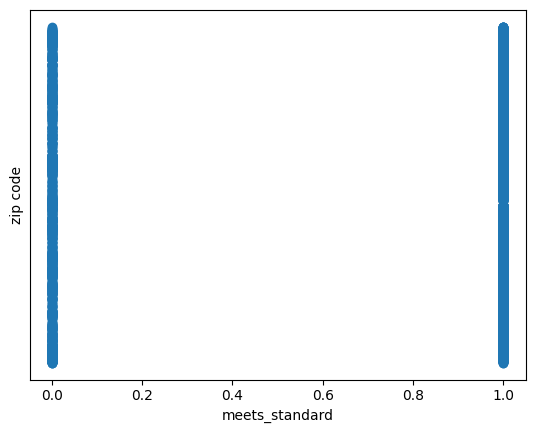

In [30]:
plt.scatter(df["meets_standards"], df["zip_code"])
plt.ylabel("zip code")
plt.yticks([])
plt.xlabel("meets_standard")
plt.show()

Perform GMM on zipcode vs bed.

In [31]:
GMMResults_bedMed = []
for x in range(1,9):
    GMMResults_bedMed.append(GMM(df_bedMed, x))

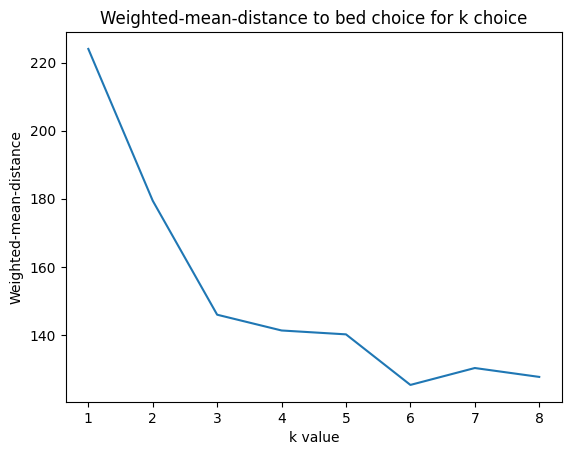

In [10]:
plt.plot(range(1,9), [kVal[-1][0] for kVal in GMMResults_bedMed])
plt.xlabel("k value")
plt.ylabel("Weighted-mean-distance")
plt.title("Weighted-mean-distance to bed choice for k choice")
plt.show()

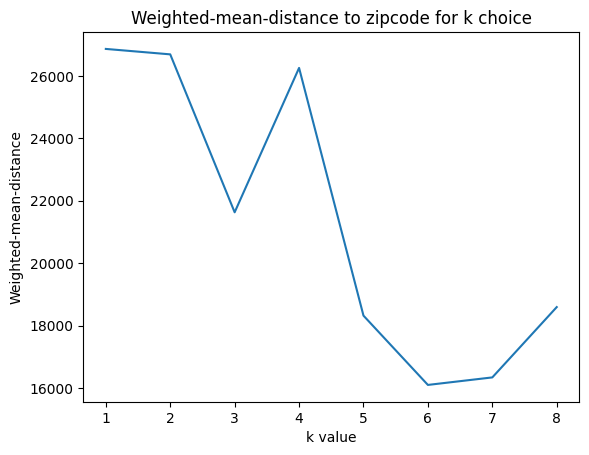

In [8]:
plt.plot(range(1,9), [kVal[-1][1] for kVal in GMMResults])
plt.xlabel("k value")
plt.ylabel("Weighted-mean-distance")
plt.title("Weighted-mean-distance to zipcode for k choice")
plt.show()

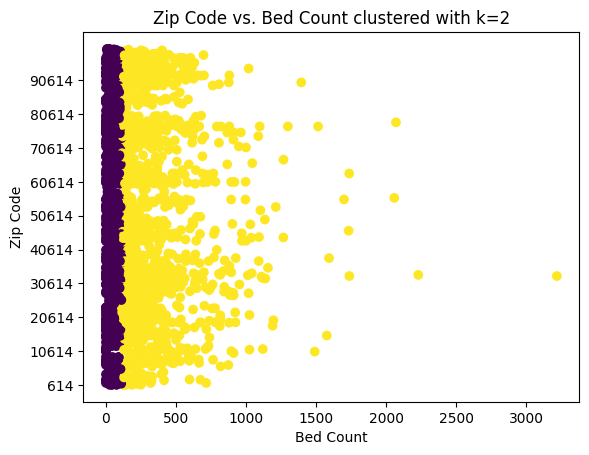

In [129]:
cluster_bedMed = np.argmax(GMMResults_bedMed[1][0], axis=1)
plt.scatter(df_bedMed['bed_count'], df_bedMed['zip_code'], c=cluster_bedMed)
plt.yticks(np.arange(min(df_bedMed["zip_code"]), max(df_bedMed["zip_code"])+1, 10000))
plt.title("Zip Code vs. Bed Count clustered with k=2")
plt.ylabel("Zip Code")
plt.xlabel("Bed Count")
plt.show()

Perform GMM on Medicare vs. Bed Count

In [26]:
GMMResults_bedMedicare = []
for x in range(1,9):
    GMMResults_bedMedicare.append(GMM(df_bedMedicare, x))

/var/folders/29/818nv1qj7z1c_zb46ggt489m0000gn/T/ipykernel_97312/2360226360.py:58: RuntimeWarning: invalid value encountered in scalar divide
  means[m, 0] = (weightValLat / sumCol)
/var/folders/29/818nv1qj7z1c_zb46ggt489m0000gn/T/ipykernel_97312/2360226360.py:59: RuntimeWarning: invalid value encountered in scalar divide
  means[m, 1] = (weightValLng / sumCol)
/var/folders/29/818nv1qj7z1c_zb46ggt489m0000gn/T/ipykernel_97312/2360226360.py:70: RuntimeWarning: invalid value encountered in divide
  covars[m, :, :] = covar/sumCol


ValueError: array must not contain infs or NaNs

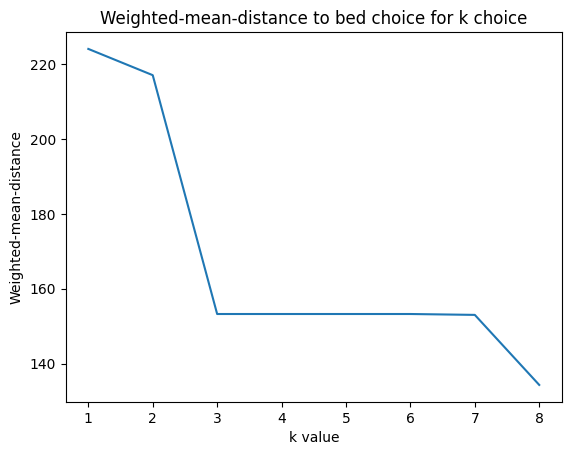

In [14]:
plt.plot(range(1,9), [kVal[-1][0] for kVal in GMMResults_bedMedicare])
plt.xlabel("k value")
plt.ylabel("Weighted-mean-distance")
plt.title("Weighted-mean-distance to bed choice for k choice")
plt.show()

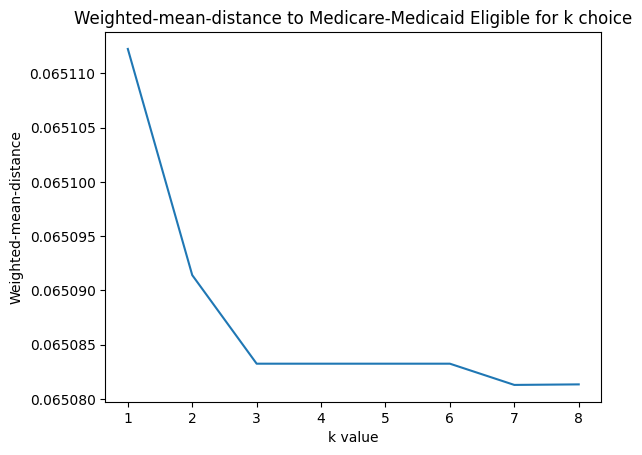

In [15]:
plt.plot(range(1,9), [kVal[-1][1] for kVal in GMMResults_bedMedicare])
plt.xlabel("k value")
plt.ylabel("Weighted-mean-distance")
plt.title("Weighted-mean-distance to Medicare-Medicaid Eligible for k choice")
plt.show()

In [21]:
cluster_bedMedicare = np.argmax(GMMResults_bedMedicare[1][0], axis=1)
plt.scatter(df_bedMedicare['bed_count'], df_bedMedicare['medicare_medicaid_eligible'], c=cluster_bedMedicare)
# plt.yticks(np.arange(min(df_bedMedicare["medicare_medicaid_eligible"]), max(df_bedMedicare["medicare_medicaid_eligible"])+1, 10000))
plt.ylabel("Medicare Medicaid Eligibility")
plt.xlabel("Bed Count")
plt.title("Zip Code vs. Medicare Medicaid Eligibility clustered with k=2")
plt.show()

NameError: name 'GMMResults_bedMedicare' is not defined

Perform GMM on State/Region vs. Bed count

In [106]:
GMMResults_bedRegion = []
for x in range(1,9):
    GMMResults_bedRegion.append(GMM(df_bedRegion, x))

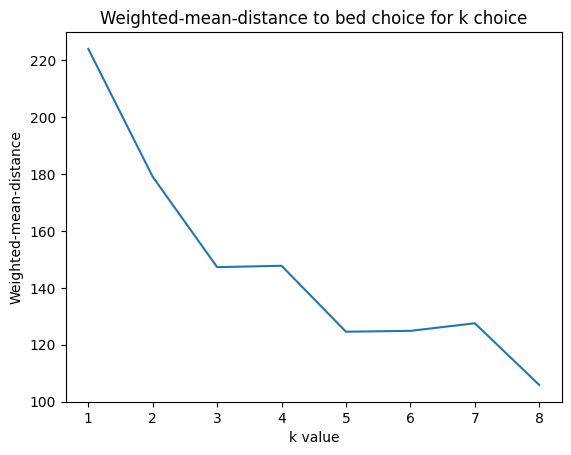

In [107]:
plt.plot(range(1,9), [kVal[-1][0] for kVal in GMMResults_bedRegion])
plt.xlabel("k value")
plt.ylabel("Weighted-mean-distance")
plt.title("Weighted-mean-distance to bed choice for k choice")
plt.show()

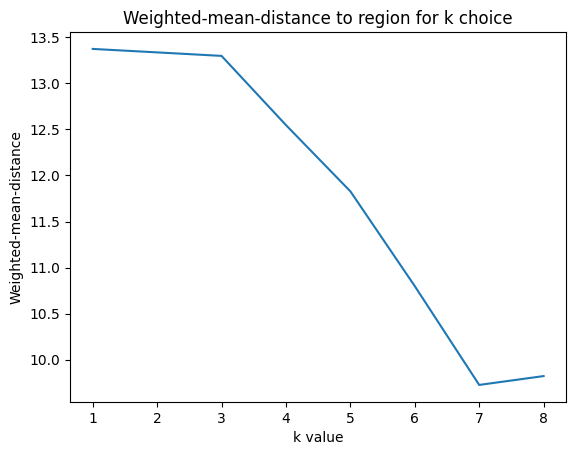

In [108]:
plt.plot(range(1,9), [kVal[-1][1] for kVal in GMMResults_bedRegion])
plt.xlabel("k value")
plt.ylabel("Weighted-mean-distance")
plt.title("Weighted-mean-distance to region for k choice")
plt.show()

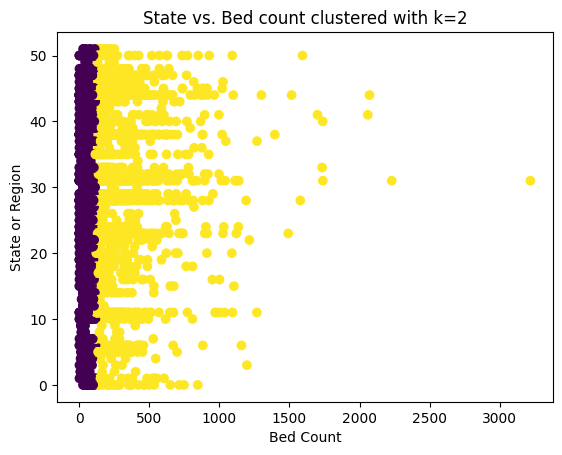

In [118]:
cluster_bedRegion = np.argmax(GMMResults_bedRegion[1][0], axis=1)
plt.scatter(df_bedRegion['bed_count'], df_bedRegion['state_or_region'], c=cluster_bedRegion)
# plt.yticks(np.arange(min(df_bedMedicare["medicare_medicaid_eligible"]), max(df_bedMedicare["medicare_medicaid_eligible"])+1, 10000))
plt.ylabel("State or Region")
plt.xlabel("Bed Count")
plt.title("State vs. Bed count clustered with k=2")
plt.show()

Calculate similarity of clusters to "meets_standards"

In [126]:
comparison_df = pd.DataFrame(cluster_bedMedicare == df["meets_standards"].replace({True: 1, False: 0}))
if comparison_df.value_counts()[0] > comparison_df.value_counts()[1]:
    print(comparison_df.value_counts()[0]/len(comparison_df))
else:
    print(comparison_df.value_counts()[1]/len(comparison_df))

0.6741413567981833


In [127]:
comparison_df = pd.DataFrame(cluster_bedMed == df["meets_standards"].replace({True: 1, False: 0}))
if comparison_df.value_counts()[0] > comparison_df.value_counts()[1]:
    print(comparison_df.value_counts()[0]/len(comparison_df))
else:
    print(comparison_df.value_counts()[1]/len(comparison_df))

0.536474595515186


In [128]:
comparison_df = pd.DataFrame(cluster_bedRegion == df["meets_standards"].replace({True: 1, False: 0}))
if comparison_df.value_counts()[0] > comparison_df.value_counts()[1]:
    print(comparison_df.value_counts()[0]/len(comparison_df))
else:
    print(comparison_df.value_counts()[1]/len(comparison_df))

0.5384615384615384
